## Computer vision 2022 Assignment 3: Deep Learning for Perception Tasks

# Question 1: A simple classifier (60%)

Q1.1 (1 point) Change the learning rate and train for 10 epochs. Fill this table:

|Lr|Accuracy|
|---|---|
|1   |   19.92%   |
|0.1|     87.22%     |
|0.01|     83.67%    |
|0.001  |    87.5%    |


Q1.2 (2 point) Report the number of epochs when the accuracy reaches 90%. Fill this table:

|Lr|Accuracy|Epoch|
|---|---|---|
|1   |   10%   |   11  |
|0.1|     90%     |  174  |
|0.01|    89.04%     |  273  |
|0.001  |    87.2%    |   297  |


Q1.3 (2 points) Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?

From the table 1 and table 2, I notice that smaller learning rates necessitate more training epochs because of the fewer changes. On the other hand, larger learning rates result in faster changes.

Q1.4 (3 point) Build a deeper/ wider network. Report the accuracy and the parameters for each structure. Parameters represent the number of trainable parameters in your model, e.g. a 3 x 3 conv has 9 parameters.

|Structures|Accuracy|Parameters|
|---|---|---|
|Base   |   87.22%   |  669,706|
|Deeper|  89.4%        |   674,836|
|Wider|    90.3%     |   1,863,690|


Q1.5 (2 points) Choose to do one of the following two tasks:

a. Write a code to calculate the parameter and expian the code.

OR

b. Write done the process of how to calculate the parameters by hand. 


Q1.6 (1 points) What are your observations and conclusions for changing network structure?

With the increasing of the parameters, the accuracy will also increase.

In [18]:
import numpy as np # This is for mathematical operations

# this is used in plotting 
import matplotlib.pyplot as plt 
import time
import pylab as pl
from IPython import display

from a3 import *
from torchinfo import summary

%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. 
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets. 
##Every TorchVision Dataset includes two arguments: 
##transform and target_transform to modify the samples and labels respectively.


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [20]:
batch_size = 64
# wandb.log({'batch_size': batch_size})

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    # print("Shape of X [N, C, H, W]: ", X.shape)
    # print("Shape of y: ", y.shape, y.dtype)
    break

In [21]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
# print("Using {} device".format(device))

# Define model --> base
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
# summary(model, (1, 28, 28))

In [22]:
# Define a model --> wider
# create a wider model
class wider_model(nn.Module):
    def __init__(self):
        super(wider_model, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
wide_model = wider_model().to(device)
# summary(wide_model, (1, 28, 28))

In [23]:
# Define a model --> deeper
# create a deeper model
class deeper_model(nn.Module):
    def __init__(self):
        super(deeper_model, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU(),
            nn.Linear(10, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
deep_model = deeper_model().to(device)
# summary(deep_model)

# Q1.1

## Learning rate = 1.0

In [21]:
grads = []
train_loss = []   
def train(dataloader, model, loss_fn, optimizer):
    steps = 0
    steps_flag = True
    
    loss_store = []
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        steps += 1
        if steps_flag:
            g1 = model.linear_relu_stack[0].weight.grad.mean()
            g2 = model.linear_relu_stack[2].weight.grad.mean()
            g3 = model.linear_relu_stack[4].weight.grad.mean()
            grads.append(np.mean([g1, g2, g3]))
            
            if steps > 100:
                steps_flag = False
        # train_loss.append(loss.item())
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            loss_store.append(loss)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    train_loss.append(np.mean(loss_store))

acc = []
test_loss_store = []
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # store the loss
    test_loss_store.append(test_loss)
    correct /= size
    acc.append(correct)
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:
# Train and test the model 
loss_fn, optimizer = sgd_optimizer(model, lr=1)
epochs = 100
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

    # print(acc)
    # print(train_loss)
    # wandb.log({'train_loss': train_loss, 'test_loss': test_loss, 'acc': acc, 'mean_loss': mean_loss})

print("Done!")

Done!


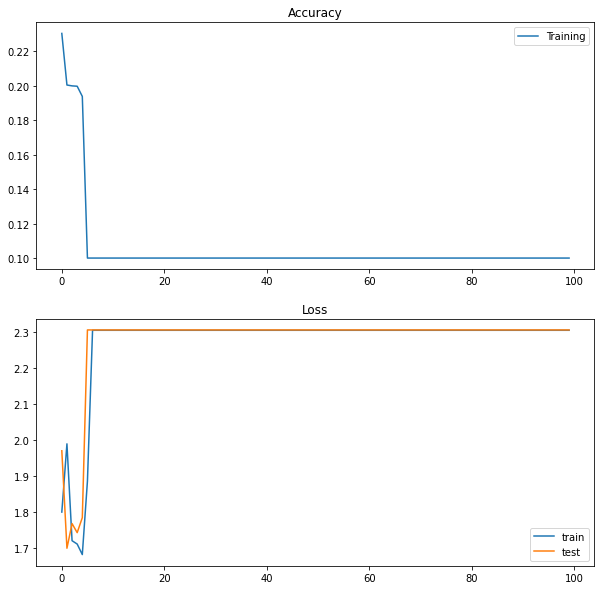

In [23]:
# plot the accuracy and loss of the model
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title("Accuracy")
plt.plot(acc, label="Training")
plt.legend()
plt.subplot(2,1,2)
plt.title("Loss")
plt.plot(train_loss, label="train")
plt.plot(test_loss_store, label="test")
plt.legend()
plt.show()

***

## Learning rate = 0.1

In [5]:
grads = []
train_loss = []   
def train(dataloader, model, loss_fn, optimizer):
    steps = 0
    steps_flag = True
    
    loss_store = []
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        steps += 1
        if steps_flag:
            g1 = model.linear_relu_stack[0].weight.grad.mean()
            g2 = model.linear_relu_stack[2].weight.grad.mean()
            g3 = model.linear_relu_stack[4].weight.grad.mean()
            grads.append(np.mean([g1, g2, g3]))
            
            if steps > 100:
                steps_flag = False
        # train_loss.append(loss.item())
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            loss_store.append(loss)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    train_loss.append(np.mean(loss_store))

acc = []
test_loss_store = []
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # store the loss
    test_loss_store.append(test_loss)
    correct /= size
    acc.append(correct)
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [6]:
# Train and test the model 
loss_fn, optimizer = sgd_optimizer(model, lr=0.1)
epochs = 100
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

    # print(acc)
    # print(train_loss)
    # wandb.log({'train_loss': train_loss, 'test_loss': test_loss, 'acc': acc, 'mean_loss': mean_loss})

print("Done!")

Done!


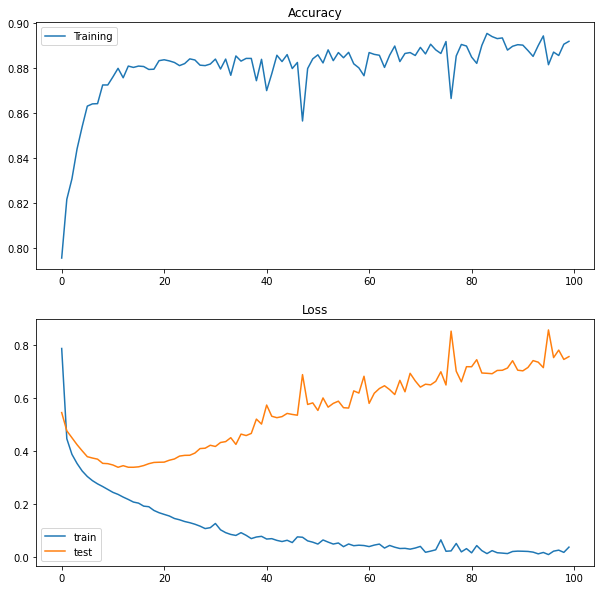

In [7]:
# plot the accuracy and loss of the model
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title("Accuracy")
plt.plot(acc, label="Training")
plt.legend()
plt.subplot(2,1,2)
plt.title("Loss")
plt.plot(train_loss, label="train")
plt.plot(test_loss_store, label="test")
plt.legend()
plt.show()

***

## Learning rate = 0.01

In [7]:
grads = []
train_loss = []   
def train(dataloader, model, loss_fn, optimizer):
    steps = 0
    steps_flag = True
    
    loss_store = []
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        steps += 1
        if steps_flag:
            g1 = model.linear_relu_stack[0].weight.grad.mean()
            g2 = model.linear_relu_stack[2].weight.grad.mean()
            g3 = model.linear_relu_stack[4].weight.grad.mean()
            grads.append(np.mean([g1, g2, g3]))
            
            if steps > 100:
                steps_flag = False
        # train_loss.append(loss.item())
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            loss_store.append(loss)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    train_loss.append(np.mean(loss_store))

acc = []
test_loss_store = []
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # store the loss
    test_loss_store.append(test_loss)
    correct /= size
    acc.append(correct)
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
# Train and test the model 
loss_fn, optimizer = sgd_optimizer(model, lr=0.01)
epochs = 100
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

    # print(acc)
    # print(train_loss)
    # wandb.log({'train_loss': train_loss, 'test_loss': test_loss, 'acc': acc, 'mean_loss': mean_loss})

print("Done!")

Done!


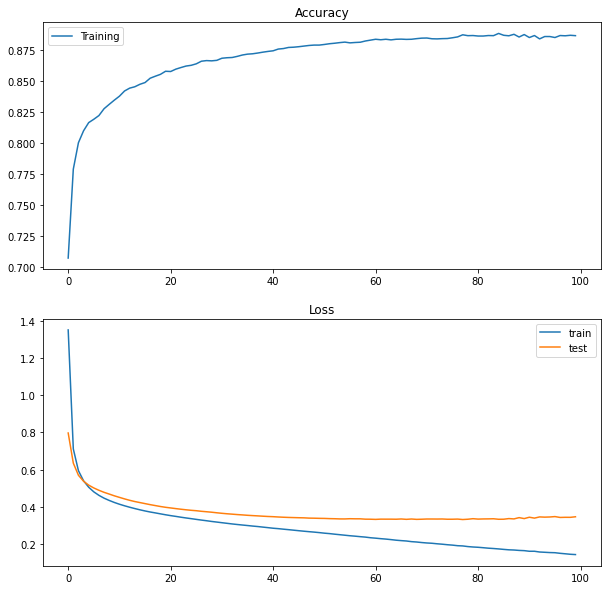

In [9]:
# plot the accuracy and loss of the model
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title("Accuracy")
plt.plot(acc, label="Training")
plt.legend()
plt.subplot(2,1,2)
plt.title("Loss")
plt.plot(train_loss, label="train")
plt.plot(test_loss_store, label="test")
plt.legend()
plt.show()

***

## Learning rate = 0.001

In [24]:
grads = []
train_loss = []   
def train(dataloader, model, loss_fn, optimizer):
    steps = 0
    steps_flag = True
    
    loss_store = []
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        steps += 1
        if steps_flag:
            g1 = model.linear_relu_stack[0].weight.grad.mean()
            g2 = model.linear_relu_stack[2].weight.grad.mean()
            g3 = model.linear_relu_stack[4].weight.grad.mean()
            grads.append(np.mean([g1, g2, g3]))
            
            if steps > 100:
                steps_flag = False
        # train_loss.append(loss.item())
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            loss_store.append(loss)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    train_loss.append(np.mean(loss_store))

acc = []
test_loss_store = []
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # store the loss
    test_loss_store.append(test_loss)
    correct /= size
    acc.append(correct)
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [25]:
# Train and test the model 
loss_fn, optimizer = sgd_optimizer(model, lr=0.001)
epochs = 100
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

    # print(acc)
    # print(train_loss)
    # wandb.log({'train_loss': train_loss, 'test_loss': test_loss, 'acc': acc, 'mean_loss': mean_loss})

print("Done!")

Done!


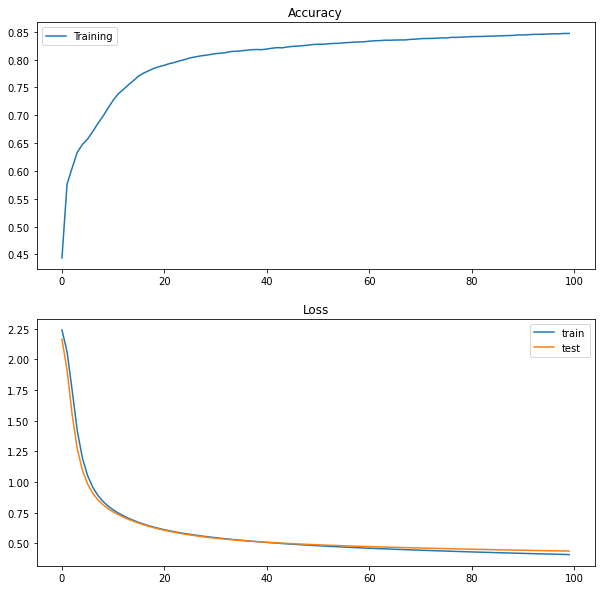

In [26]:
# plot the accuracy and loss of the model
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title("Accuracy")
plt.plot(acc, label="Training")
plt.legend()
plt.subplot(2,1,2)
plt.title("Loss")
plt.plot(train_loss, label="train")
plt.plot(test_loss_store, label="test")
plt.legend()
plt.show()

***

# Q1.7

## Learning rate = 1.0

In [8]:
grads = []
train_loss = []   
def train(dataloader, model, loss_fn, optimizer):
    steps = 0
    steps_flag = True
    
    loss_store = []
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        steps += 1
        if steps_flag:
            g1 = model.linear_relu_stack[0].weight.grad.mean()
            g2 = model.linear_relu_stack[2].weight.grad.mean()
            g3 = model.linear_relu_stack[4].weight.grad.mean()
            grads.append(np.mean([g1, g2, g3]))
            
            if steps > 100:
                steps_flag = False
        # train_loss.append(loss.item())
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            loss_store.append(loss)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    train_loss.append(np.mean(loss_store))

acc = []
test_loss_store = []
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # store the loss
    test_loss_store.append(test_loss)
    correct /= size
    acc.append(correct)
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
# Train and test the model 
loss_fn, optimizer = sgd_optimizer(model, lr=1)
epochs = 1
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

    # print(acc)
    # print(train_loss)
    # wandb.log({'train_loss': train_loss, 'test_loss': test_loss, 'acc': acc, 'mean_loss': mean_loss})

print("Done!")

Done!


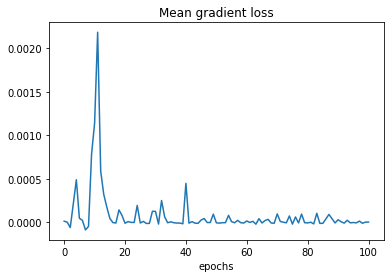

In [10]:
# plot the mean gradient loss
plt.title("Mean gradient loss")
plt.plot(grads, label='mean_grad_loss')
plt.xlabel('epochs')
plt.show()

***

## Learning rate = 0.1

In [11]:
grads = []
train_loss = []   
def train(dataloader, model, loss_fn, optimizer):
    steps = 0
    steps_flag = True
    
    loss_store = []
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        steps += 1
        if steps_flag:
            g1 = model.linear_relu_stack[0].weight.grad.mean()
            g2 = model.linear_relu_stack[2].weight.grad.mean()
            g3 = model.linear_relu_stack[4].weight.grad.mean()
            grads.append(np.mean([g1, g2, g3]))
            
            if steps > 100:
                steps_flag = False
        # train_loss.append(loss.item())
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            loss_store.append(loss)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    train_loss.append(np.mean(loss_store))

acc = []
test_loss_store = []
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # store the loss
    test_loss_store.append(test_loss)
    correct /= size
    acc.append(correct)
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
# Train and test the model 
loss_fn, optimizer = sgd_optimizer(model, lr=0.1)
epochs = 1
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

    # print(acc)
    # print(train_loss)
    # wandb.log({'train_loss': train_loss, 'test_loss': test_loss, 'acc': acc, 'mean_loss': mean_loss})

print("Done!")

Done!


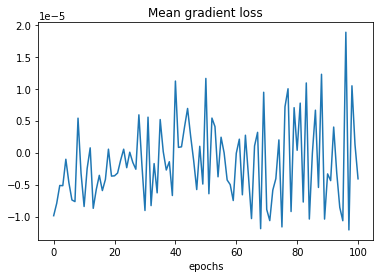

In [13]:
# plot the mean gradient loss
plt.title("Mean gradient loss")
plt.plot(grads, label='mean_grad_loss')
plt.xlabel('epochs')
plt.show()

****

## Learning rate = 0.01

In [15]:
grads = []
train_loss = []   
def train(dataloader, model, loss_fn, optimizer):
    steps = 0
    steps_flag = True
    
    loss_store = []
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        steps += 1
        if steps_flag:
            g1 = model.linear_relu_stack[0].weight.grad.mean()
            g2 = model.linear_relu_stack[2].weight.grad.mean()
            g3 = model.linear_relu_stack[4].weight.grad.mean()
            grads.append(np.mean([g1, g2, g3]))
            
            if steps > 100:
                steps_flag = False
        # train_loss.append(loss.item())
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            loss_store.append(loss)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    train_loss.append(np.mean(loss_store))

acc = []
test_loss_store = []
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # store the loss
    test_loss_store.append(test_loss)
    correct /= size
    acc.append(correct)
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [16]:
# Train and test the model 
loss_fn, optimizer = sgd_optimizer(model, lr=0.01)
epochs = 1
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

    # print(acc)
    # print(train_loss)
    # wandb.log({'train_loss': train_loss, 'test_loss': test_loss, 'acc': acc, 'mean_loss': mean_loss})

print("Done!")

Done!


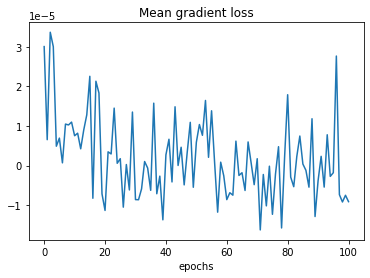

In [17]:
# plot the mean gradient loss
plt.title("Mean gradient loss")
plt.plot(grads, label='mean_grad_loss')
plt.xlabel('epochs')
plt.show()

***

## Learning rate = 0.001

In [27]:
grads = []
train_loss = []   
def train(dataloader, model, loss_fn, optimizer):
    steps = 0
    steps_flag = True
    
    loss_store = []
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        steps += 1
        if steps_flag:
            g1 = model.linear_relu_stack[0].weight.grad.mean()
            g2 = model.linear_relu_stack[2].weight.grad.mean()
            g3 = model.linear_relu_stack[4].weight.grad.mean()
            grads.append(np.mean([g1, g2, g3]))
            
            if steps > 100:
                steps_flag = False
        # train_loss.append(loss.item())
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            loss_store.append(loss)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    train_loss.append(np.mean(loss_store))

acc = []
test_loss_store = []
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # store the loss
    test_loss_store.append(test_loss)
    correct /= size
    acc.append(correct)
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [28]:
# Train and test the model 
loss_fn, optimizer = sgd_optimizer(model, lr=0.001)
epochs = 1
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

    # print(acc)
    # print(train_loss)
    # wandb.log({'train_loss': train_loss, 'test_loss': test_loss, 'acc': acc, 'mean_loss': mean_loss})

print("Done!")

Done!


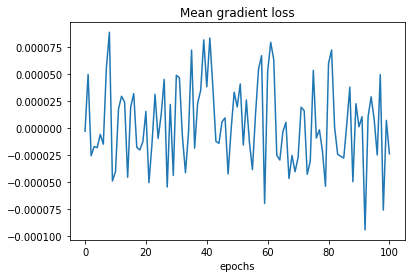

In [29]:
# plot the mean gradient loss
plt.title("Mean gradient loss")
plt.plot(grads, label='mean_grad_loss')
plt.xlabel('epochs')
plt.show()

**Observation:**
The trend of the curve is showing a downward trend in each learning rate.
As the learning rate decreases, we find that the amplitude of the curve becomes larger.
As the learning rate decreases, we find that the downward trend of the curve becomes obvious。

## More information

I also made a detaided graph by using wandb.

You can check it in this link:
https://wandb.ai/xiaolinzzz/Assignment%203/reports/A3-Report--VmlldzoxOTgwMDAw?accessToken=idh3yza0zi15hp9co3svy1bk91wlkjkmf355fwahj2b64guf8usdro7tu6ximq31

# Question 2: Proposal for Practical Applications (40%)
Look for a typical computer vision problem, such as:
a. removing noise on the image

b. increasing the resolution of the image

c. identifying objects in the image

d. segmenting the area to which the image belongs

e. estimating the depth of an object

f. estimating the motion of two object in different frames

h. others

Discuss possible applications of this problem in life, e.g. image editing systems in your phone, improved quality of the old film, sweeping robot avoiding obstacles, unlocks the face of the mobile phone, identifies the cancer area according to the medical scan image, determines the identity according to the face, identifies the trash can on the road, and the detection system tracks the target object, etc.

In this question, you need to do
1. Clearly define the problem and describe its application scenarios
2. Briefly describe a feasible solution based on image processing and traditional machine learning algorithms.
3. Briefly describe a feasible deep learning-based solution.
4. Compare the advantages and disadvantages of the two options.

Hint1: Submit an individua report for question 2.

Hint2: Well orginaze your report.

Hint3: You can draw flow chart or inculde other figures for better understanding of your solution.  

Please restrict your report within 800 words. In this question, you do not need to implement your solution. You only need to write down a proposal. Please submit this report in a seperate pdf. 

